In [1]:
import numpy as np
from numpy import loadtxt
import fitsio
import healpy as hp
import healsparse as hsp
import skyproj
import matplotlib.pyplot as plt
import Config
from astropy.table import Table
import os
from os import listdir
# import skymap
# from skymap import Skymap,McBrydeSkymap,OrthoSkymap

In [2]:
dirStars = '/hdfs/bechtol/balrog/y3/y3a2_gold_v2p2_skim/healpixel/'
dirTrain = '/hdfs/bechtol/balrog/y3/y3a2_survey_conditions_maps/Kyle_Stuff/training/'
files = os.listdir(dirStars)
res = 4096
usedCols = ['HPIX_4096', 'FLAGS_FOREGROUND', 'FLAGS_BADREGIONS', 'FLAGS_FOOTPRINT', 'EXTENDED_CLASS_SOF', 'SOF_PSF_MAG_G', 'SOF_PSF_MAG_R']
numBins = 100

In [3]:
validPix = fitsio.read(dirTrain + 'Valid_4096_Pixels.fits')['PIXEL']

In [4]:
pixCheck = np.full(12*(4096**2), False, dtype = bool)
pixCheck[validPix] = True

In [5]:
PIX = []
FOREGROUND = []
BADREGIONS = []
FOOTPRINT = []
CLASS = []

for file in files:
    starData = fitsio.read(dirStars + file, columns = usedCols)
    FOREGROUND = starData[usedCols[1]]
    BADREGIONS = starData[usedCols[2]]
    FOOTPRINT = starData[usedCols[3]]
    CLASS = starData[usedCols[4]]
    GMAG = starData[usedCols[5]]
    RMAG = starData[usedCols[6]]
    
    cutIndices = np.where((FOREGROUND == 0) & 
                      (BADREGIONS < 2) & 
                      (FOOTPRINT == 1) & 
                      (CLASS <= 1) & 
                      (CLASS >= 0) &
                      ((GMAG - RMAG) <= 1) &
                      ((GMAG - RMAG) >= -0.3))[0]
     
    allPIX = starData[usedCols[0]][cutIndices]
    
    trimPIX = allPIX[np.where(pixCheck[allPIX])[0]]
    
    PIX.extend(trimPIX)
    
PIX = np.array(PIX)

In [6]:
PIX = np.array(PIX)

# This converts the RA and DEC values from above to healpixels so we can compare to the sky condition.
starPIXRepeats = PIX

# This sorts by the pixel in order to make following methods more efficient.
sortInds = starPIXRepeats.argsort()
starPIXRepeats = starPIXRepeats[sortInds[::1]]
starDETRepeats = np.zeros(len(starPIXRepeats))

# These are indices that will be looping through the pixStar and starPix arrays in parallel.
uniqInd = 0
starInd = 0

# This will be used to store the number of stars at each pixel.
starPIX = np.unique(starPIXRepeats) # The unique pixels, with no repeats.
starDET = np.zeros_like(starPIX)

while starInd < len(starPIXRepeats):
    if starPIX[uniqInd] == starPIXRepeats[starInd]: # If the pixels match up in the arrays.
        starDET[uniqInd] += 1                # Add one for the detection..
        starInd += 1                         # Add one to the starInd to see if the next index in starPix is also the same.
        # Since the last index of pixStar and starPix are the same, starInd will increase the last time through the loop,
        # making this the index that we must restrict in the while loop.
    else:
        uniqInd += 1 # If the pixels are no longer the same, increase the index you check in the pixStar array.

In [7]:
corrections = fitsio.read(dirTrain + 'Blue_Corrections_Map.fits')['SIGNAL']

In [8]:
corrPerPix = np.full(12*(4096**2), -1000.0)
corrPerPix[validPix] = corrections

In [9]:
origStarDET = starDET
starDET = starDET * corrPerPix[starPIX]

In [10]:
origFullMap = np.full(12*(4096**2), hp.UNSEEN)
origFullMap[validPix] = 0
origFullMap[starPIX] = origStarDET

In [11]:
fullMap = np.full(12*(4096**2), hp.UNSEEN)
fullMap[validPix] = 0
fullMap[starPIX] = starDET

In [12]:
stelDensData = fitsio.read('/hdfs/bechtol/balrog/y3/y3a2_survey_conditions_maps/Kyle_Stuff/training/Stellar Density.fits')['SIGNAL']
stelDensExt = np.full(12*(4096**2), 0.0)
stelDensExt[validPix] = stelDensData
stelDens = np.full(12*(4096**2), hp.UNSEEN)
stelDens[starPIX] = stelDensExt[starPIX]
stelDens = 64 * hp.ud_grade(stelDens, 512, order_in = 'NESTED', order_out = 'NESTED')
stelDens[np.where(stelDens <= hp.UNSEEN)] = hp.UNSEEN

stelDens = hp.pixelfunc.reorder(hp.sphtfunc.smoothing(hp.pixelfunc.reorder(stelDens, n2r = True), sigma = 0.01), r2n = True)

# stelDens = hp.pixelfunc.ma(stelDens, hp.UNSEEN)
# stelDens.fill_value = np.ma.median(stelDens)
# smooth = hp.smoothing(stelDens, sigma=np.radians(1), verbose=False)
# stelDens = np.ma.array(smooth,mask=stelDens.mask)

In [13]:
stelDensHsp = hsp.HealSparseMap(nside_coverage=32, healpix_map=stelDens)

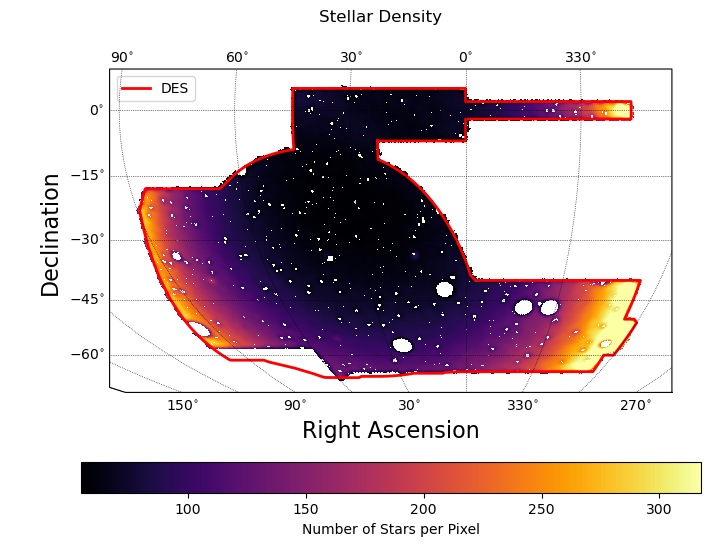

In [14]:
# The default DES projection is a McBrydeSkymap.
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
sp = skyproj.DESSkyproj(ax=ax)
sp.draw_des(label='DES')
sp.draw_hspmap(stelDensHsp, cmap = 'inferno')
# plt.clim(50, 375)
plt.colorbar(location = 'bottom', label = 'Number of Stars per Pixel')
fig.suptitle('Stellar Density')
sp.legend()
plt.show()

In [15]:
fracFile = '/hdfs/bechtol/balrog/y3/y3a2_survey_conditions_maps/fracdet/y3a2_griz_o.4096_t.32768_coverfoot_EQU.fits.gz'
fracData = fitsio.read(fracFile)

In [16]:
fracPix = fracData['PIXEL']
fracDet = fracData['SIGNAL']
fracMap = np.full(12*(4096**2), 0.0)
fracMap[fracPix] = fracDet
fracMap = hp.ud_grade(fracMap, 512, order_in = 'NESTED', order_out = 'NESTED')
fracPix = np.where(fracMap >= 0.75)[0]
fracMap[np.where(fracMap < 0.75)[0]] = hp.UNSEEN

In [17]:
badFracPix = np.full(12*(512**2), True, dtype = bool)
badFracPix[fracPix] = False

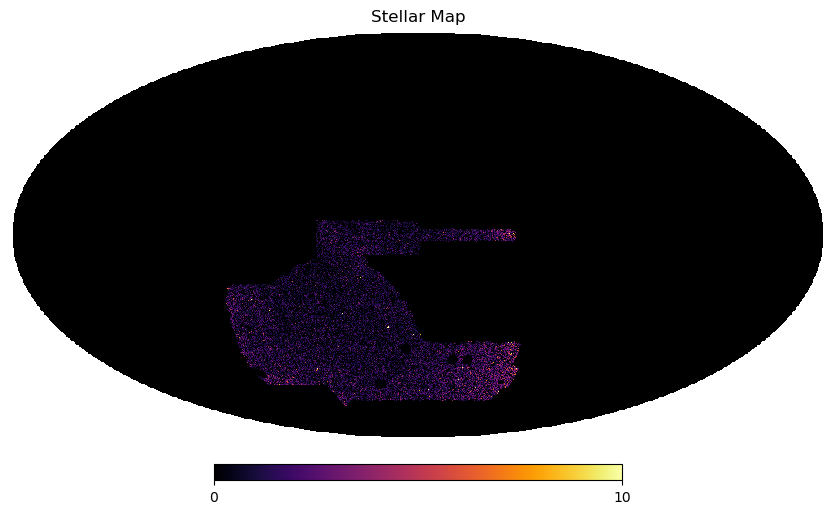

In [18]:
hp.mollview(fullMap, nest=True, title="Stellar Map", min = 0, max = 10, badcolor = 'black', cmap = 'inferno', xsize = 1000)

In [20]:
map512 = 64 * hp.ud_grade(fullMap, 512, order_in = 'NESTED', order_out = 'NESTED')
map512 = map512 / fracMap
# map512 = map512 / stelDens
map512[np.where(map512 == 0)[0]] = hp.UNSEEN
map512[badFracPix] = hp.UNSEEN

In [21]:
origMap512 = 64 * hp.ud_grade(origFullMap, 512, order_in = 'NESTED', order_out = 'NESTED')
origMap512 = origMap512 / fracMap
# origMap512 = origMap512 / stelDens
origMap512[np.where(origMap512 == 0)[0]] = hp.UNSEEN
origMap512[badFracPix] = hp.UNSEEN

In [22]:
nside_coverage = 32
hspMap512 = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=map512)
origHspMap512 = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=origMap512)
hspMap4096 = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=fullMap)

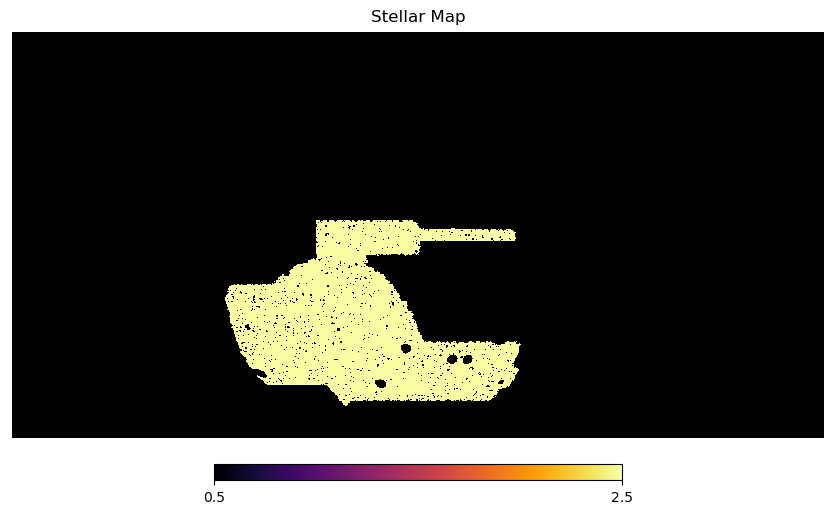

In [23]:
hp.mollview(map512, nest=True, title="Stellar Map", min = 0.5, max = 2.5, badcolor = 'black', cmap = 'inferno', xsize = 1000)

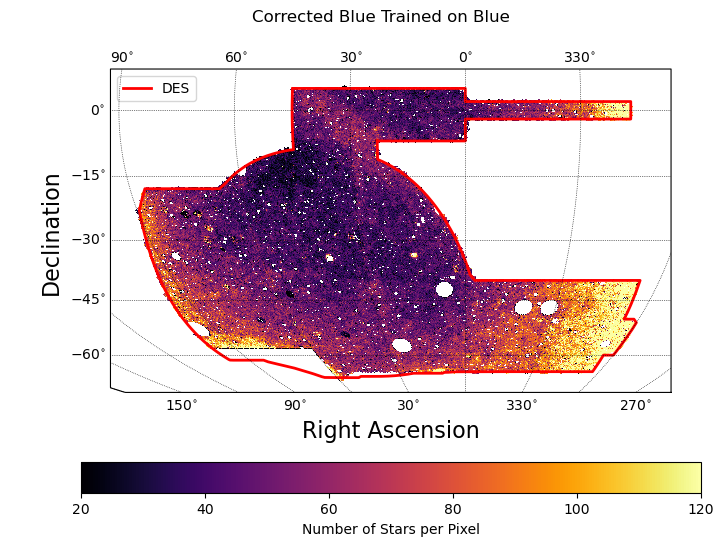

In [27]:
# The default DES projection is a McBrydeSkymap.
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
sp = skyproj.DESSkyproj(ax=ax)
sp.draw_des(label='DES')
sp.draw_hspmap(hspMap512, cmap = 'inferno')
# plt.clim(0.5, 2.5)
plt.clim(20, 120)
plt.colorbar(location = 'bottom', label = 'Number of Stars per Pixel')
fig.suptitle('Corrected Blue Trained on Blue')
sp.legend()
plt.show()

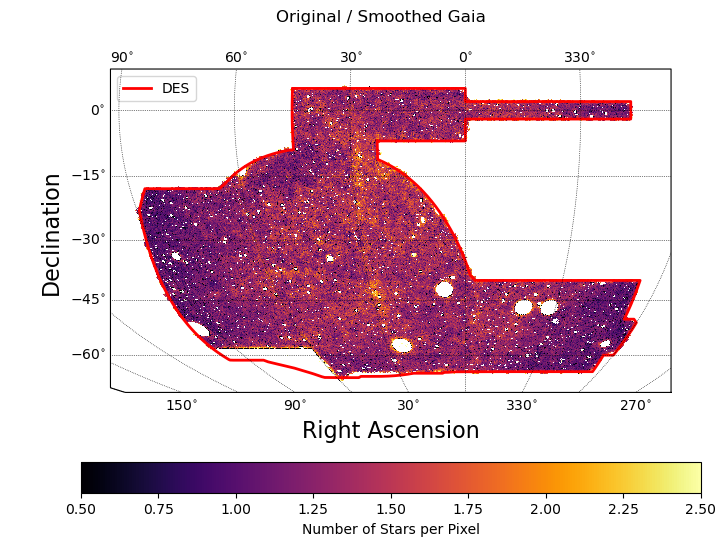

In [47]:
# The default DES projection is a McBrydeSkymap.
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
sp = skyproj.DESSkyproj(ax=ax)
sp.draw_des(label='DES')
sp.draw_hspmap(origHspMap512, cmap = 'inferno')
plt.clim(0.5, 2.5)
# plt.clim(50, 375)
plt.colorbar(location = 'bottom', label = 'Number of Stars per Pixel')
fig.suptitle('Original / Smoothed Gaia')
sp.legend()
plt.show()

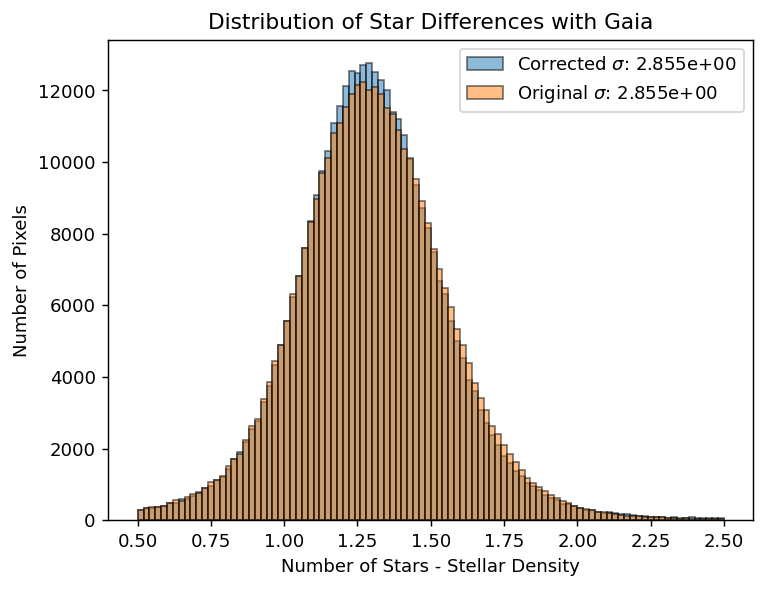

In [51]:
plt.figure(dpi = 130)
plt.hist(hspMap512[hspMap512.valid_pixels], bins = np.linspace(0.5, 2.5, 101), alpha = 0.5, edgecolor = 'black', linewidth = 1, label = 'Corrected ' + r'$\sigma$' + ': ' + str(np.format_float_scientific(np.std(hspMap512[hspMap512.valid_pixels]), precision = 3)))
plt.hist(origHspMap512[origHspMap512.valid_pixels], bins = np.linspace(0.5, 2.5, 101), alpha = 0.5, edgecolor = 'black', linewidth = 1, label = 'Original ' + r'$\sigma$' + ': ' + str(np.format_float_scientific(np.std(origHspMap512[origHspMap512.valid_pixels]), precision = 3)))
plt.legend()
plt.title('Distribution of Star Differences with Gaia')
plt.xlabel('Number of Stars - Stellar Density')
plt.ylabel('Number of Pixels')
plt.show()